<a href="https://colab.research.google.com/github/BabritB/DoubleB/blob/master/BERT_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bert
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
!pip install -qq transformers

  Created wheel for bert: filename=bert-2.2.0-cp36-none-any.whl size=3756 sha256=a56274395506b492e10227c6cbc4cdc238a19238fc6e97daf789e106d0b1e6b0
  Stored in directory: /root/.cache/pip/wheels/fe/71/b7/941459453bd38e5d97a8c886361dee19325e9933c9cf88ad46
  Created wheel for erlastic: filename=erlastic-2.0.0-cp36-none-any.whl size=6786 sha256=4470ebfece84675e16f856dc773be9885ae85216732e1086cdc0e64a36134a75
  Stored in directory: /root/.cache/pip/wheels/02/62/46/93c713a5f061aeeb4f16eb6bf5ee798816e6ddda70faa78e69
Successfully built bert erlastic
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 40.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 22.8MB/s]
     |████████████████████████████████| 778kB 4.7MB/s 
     |████████████████████████████████| 3.0MB 20.4MB/s 
     |████████████████████████████████| 1.1MB 58.9MB/s 
   

In [74]:
import pandas as pd
import numpy as np
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

In [75]:
data=pd.read_csv('reviews.csv')

In [76]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [77]:
def convert_sentiment(rating):
  rating=int(rating)
  if rating<=2:
    return 0
  elif rating==3:
    return 1
  else:
    return 2

data['sentiment']=data['score'].apply(lambda x:convert_sentiment(x))

In [78]:
class_names = ['negative', 'neutral', 'positive']

In [79]:
"""### Preprocessing stars using the BertBodel"""
PRE_TRAINED_MODEL_NAME='bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [80]:
token_lens = []
for txt in data.content:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

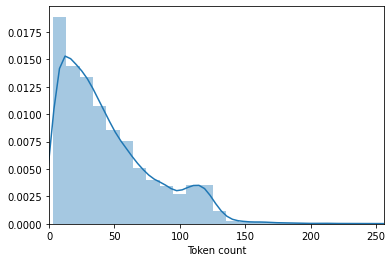

In [81]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [82]:
MAX_LEN=160

In [83]:
# Build the pytorch dataset:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      truncation=True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [84]:
data_train, data_test = train_test_split(data,test_size=0.1,random_state=RANDOM_SEED)
data_val, data_test = train_test_split(data_test,test_size=0.5,random_state=RANDOM_SEED)

In [85]:
data_train.shape, data_val.shape, data_test.shape

((14171, 12), (787, 12), (788, 12))

In [86]:
# Need to create dataloaders:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(ds,batch_size=batch_size,num_workers=4)
BATCH_SIZE = 16

In [87]:
train_data_loader = create_data_loader(data_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [89]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [90]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [91]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [92]:
#This is the raw Bert model :
last_hidden_state, pooled_output = bert_model(input_ids=data['input_ids'],attention_mask=data['attention_mask'])

In [93]:
last_hidden_state.shape

torch.Size([16, 160, 768])

In [94]:
# Create a classifier using the Bert Model:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [95]:
# Now move it to GPU:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [96]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [97]:
# To get the predicted probabilities from our trained model, we’ll apply the softmax function to the outputs:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4167, 0.1629, 0.4204],
        [0.5268, 0.1343, 0.3389],
        [0.3120, 0.1510, 0.5370],
        [0.5324, 0.1180, 0.3496],
        [0.6053, 0.1680, 0.2267],
        [0.3334, 0.1828, 0.4838],
        [0.4221, 0.1138, 0.4641],
        [0.3167, 0.2619, 0.4215],
        [0.3325, 0.1465, 0.5211],
        [0.2637, 0.1996, 0.5367],
        [0.4092, 0.1467, 0.4441],
        [0.3765, 0.2127, 0.4107],
        [0.5731, 0.0732, 0.3537],
        [0.4752, 0.1724, 0.3525],
        [0.3837, 0.1831, 0.4332],
        [0.3463, 0.2110, 0.4427]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training the Model:

### Predefined hyperparams from the authors:
Batch size: 16, 32 | 
Learning rate (Adam): 5e-5, 3e-5, 2e-5 | 
Number of epochs: 2, 3, 4

In [98]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [102]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_example):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)# We are avoiding gradient exploding: Through clipping
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_example, np.mean(losses)

In [103]:
# Eval the Model:
def eval_model(model, data_loader, loss_fn, device, n_example):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_example, np.mean(losses)

In [105]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(data_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,device,len(data_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
------------------------------
Train loss 0.3928224016485513 accuracy 0.8523745677792676
Val   loss 0.4960121926665306 accuracy 0.8335451080050826

Epoch 2/10
------------------------------
Train loss 0.22725200758191585 accuracy 0.9281631500952651
Val   loss 0.6242331060767173 accuracy 0.8678526048284626

Epoch 3/10
------------------------------
Train loss 0.16011956546447212 accuracy 0.9540611107190742
Val   loss 0.7498525661230088 accuracy 0.8691232528589581

Epoch 4/10
------------------------------
Train loss 0.10572175838843695 accuracy 0.9696563404135206
Val   loss 0.7286872366070747 accuracy 0.878017789072427

Epoch 5/10
------------------------------
Train loss 0.0774897876580332 accuracy 0.9776303718862466
Val   loss 0.7949933139979839 accuracy 0.8805590851334181

Epoch 6/10
------------------------------
Train loss 0.06398470333144574 accuracy 0.9810175710959002
Val   loss 0.8431818175315857 accuracy 0.8818297331639137

Epoch 7/10
------------------------------
T

### Now Model Evaluation

In [106]:
test_acc, _ = eval_model(model,test_data_loader,loss_fn,device,len(data_test))
test_acc.item()


0.8883248730964466

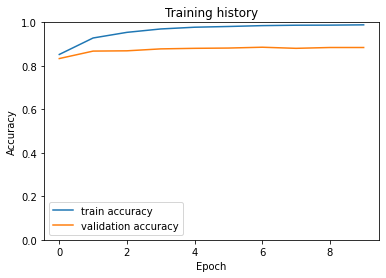

In [107]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Predicting on Raw Text

In [111]:
review_text = "The food was not good at all not even the drinks were good"
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  truncation=True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [112]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: The food was not good at all not even the drinks were good
Sentiment  : negative
